In [9]:
import pandas as pd
import math
import pickle
import datetime
import matplotlib.pyplot as plt
import numpy as np

# read in data

In [2]:
rows = []
with open('forumTest.data', "r") as fp:
    rows = [line.split(" ",1) for line in fp.readlines()]
test = pd.DataFrame(rows,columns=["subject","content"])
rows = []
with open('forumTraining.data', "r") as fp:
    rows = [line.split(" ",1) for line in fp.readlines()]
training = pd.DataFrame(rows,columns=["subject","content"])

# load

In [3]:
with open('vocab.pickle','rb') as file:
    vocab = pickle.load(file)
with open('trgroup.pickle','rb') as file:
    trgroup = pickle.load(file)
with open('probs.pickle','rb') as file:
    probs = pickle.load(file)
with open('text.pickle','rb') as file:
    text = pickle.load(file)
with open('wtprob.pickle','rb') as file:
    wtprob = pickle.load(file)

# training

In [ ]:
#collect the vocab
#run the pickle
vocab = []
for k,row in training.iterrows():
    for word in row.content.split(" "):
        if word not in vocab:
            vocab.append(word)
print('done')

# save 

In [ ]:
x = wtprob
with open('vocab.pickle','wb') as file:
    pickle.dump(vocab,file)
with open('trgroup.pickle','wb') as file:
    pickle.dump(trgroup,file)
with open('probs.pickle','wb') as file:
    pickle.dump(probs,file)
with open('text.pickle','wb') as file:
    pickle.dump(text,file)
with open('wtprob.pickle','wb') as file:
    pickle.dump(wtprob,file)

In [ ]:
#run the pickle
#calculate probability estimates 
trgroup = training.groupby('subject')
docs ={}
probs = {g:0 for g in trgroup.groups.keys()}
text = {g:'' for g in trgroup.groups.keys()} 
wtprob = {g:{} for g in trgroup.groups.keys()} 
for g, cont in trgroup:
    print(g)
    docs[g] = cont.content.tolist()
    probs[g] = len(cont)/len(training)
    for cnt in docs[g]:
        text[g] += cnt.strip()+" "
    n = len(text[g].split(' '))
    for word in vocab:
        nk = text[g].count(word)
        wtprob[g][word] = math.log((nk + 1)/(n+len(vocab)))
    print('done with '+g)
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

# Classify

In [4]:
win = 0.0
lose = 0.0
otl = 0.0
gss_act = {x:{g:0 for g in trgroup.groups.keys()} for x in trgroup.groups.keys()}
for idx,tent in test.iterrows():
    maxnb = -9999999999
    maxg = ""
    maxnb2 = maxnb
    maxg2 = ""
    for g in trgroup.groups.keys():
        tot = math.log(probs[g])
        words = tent.content.split(" ")
        for word in words:
            try:
                tot += wtprob[g][word]     
            except KeyError:
                pass
        if tot > maxnb:
            maxnb2 = maxnb
            maxg2 = maxg
            maxnb = tot
            maxg = g
            
        elif tot > maxnb2:
            maxnb2 = tot
            maxg2 = g
    gss_act[maxg][tent.subject] += 1
    if maxg == tent.subject:
        win += 1.0
    elif maxg2 == tent.subject:
        otl += 1.0
    else:
        lose += 1.0
print("%f%% 1st correct %f%% 2nd correct %f%% 1st or 2nd correct"%(win/len(test), otl/len(test), (win+otl)/len(test)))

0.752125% 1st correct 0.099761% 2nd correct 0.851886% 1st or 2nd correct


In [ ]:
for gs in gss_act:
    print(gs+"~~~~~~~~~~~~~~")
    tot = sum(gss_act[gs].values())
    acts = list(gss_act[gs].keys())
    done = False
    while not done:
        done = True
        for i in range(len(acts)-1):
            if gss_act[gs][acts[i]]<gss_act[gs][acts[i+1]]:
                done = False
                tmp = acts[i]
                acts[i] = acts[i+1]
                acts[i+1] = tmp
            
                
    for at in acts:
        print("     "+at+":"+str(gss_act[gs][at]/tot))

In [19]:
topLst = [{'subject':'','word':'','score':0}]*30
topG = {g:[{'word':'','score':0}]*5 for g in trgroup.groups.keys()}
for word in vocab:
    if(len(word)<3):
        continue
    tot = 0
    cnt = 0
    for g in trgroup.groups.keys():
        try:
            tot += math.e**wtprob[g][word]
            cnt += 1
        except KeyError as e:
            print(e)
            pass
    avg = tot/cnt
    for g in trgroup.groups.keys():
        try:
            v = (math.e**wtprob[g][word])/avg
        except KeyError:
            print(e)
            continue
        for i in range(len(topG[g])):
            if v > topG[g][i]['score']:
                for j in range(len(topG[g])-2,i,-1):
                    topG[g][j] = topG[g][j-1]
                topG[g][i] = {'word':word,'score':v}
                break
        for i in range(len(topLst)):
            if v > topLst[i]['score']:
                for j in range(len(topLst)-2,i,-1):
                    topLst[j] = topLst[j-1]
                topLst[i] = {'subject':g,'word':word,'score':v}
                break
for i in range(len(topLst)-1,-1,-1):
    print("#%d subject:%s word:%s score:%f"%(i+1,topLst[i]['subject'],topLst[i]['word'],topLst[i]['score']))
orderG = list(trgroup.groups.keys())
orderG.sort()
for g in orderG:
    print(g+"~~~~~~~~~~~~~~~~~~~~~")
    for i in range(len(topG[g])-1,-1,-1):
        print("\t%d word:%s score:%f"%(i+1,topG[g][i]['word'],topG[g][i]['score']))

#30 subject:mideastpolitics word:israe score:17.944894
#29 subject:motorcycles word:motorc score:18.081908
#28 subject:space word:lunar score:18.169763
#27 subject:mideastpolitics word:pales score:18.173181
#26 subject:space word:orbit score:18.191135
#25 subject:hockey word:leafs score:18.221307
#24 subject:hockey word:playoff score:18.253533
#23 subject:mideastpolitics word:palest score:18.409149
#22 subject:mideastpolitics word:azerbaijan score:18.481813
#21 subject:xwindows word:widget score:18.578849
#20 subject:guns word:firearm score:18.628661
#19 subject:graphics word:jpeg score:18.681200
#18 subject:politics word:stephanopoulos score:18.684670
#17 subject:mideastpolitics word:turk score:18.703059
#16 subject:mideastpolitics word:turkish score:18.742684
#15 subject:cryptology word:escrow score:18.745295
#14 subject:hockey word:hockey score:18.905565
#13 subject:mideastpolitics word:armenians score:18.941339
#12 subject:motorcycles word:bike score:18.968215
#11 subject:hockey wo

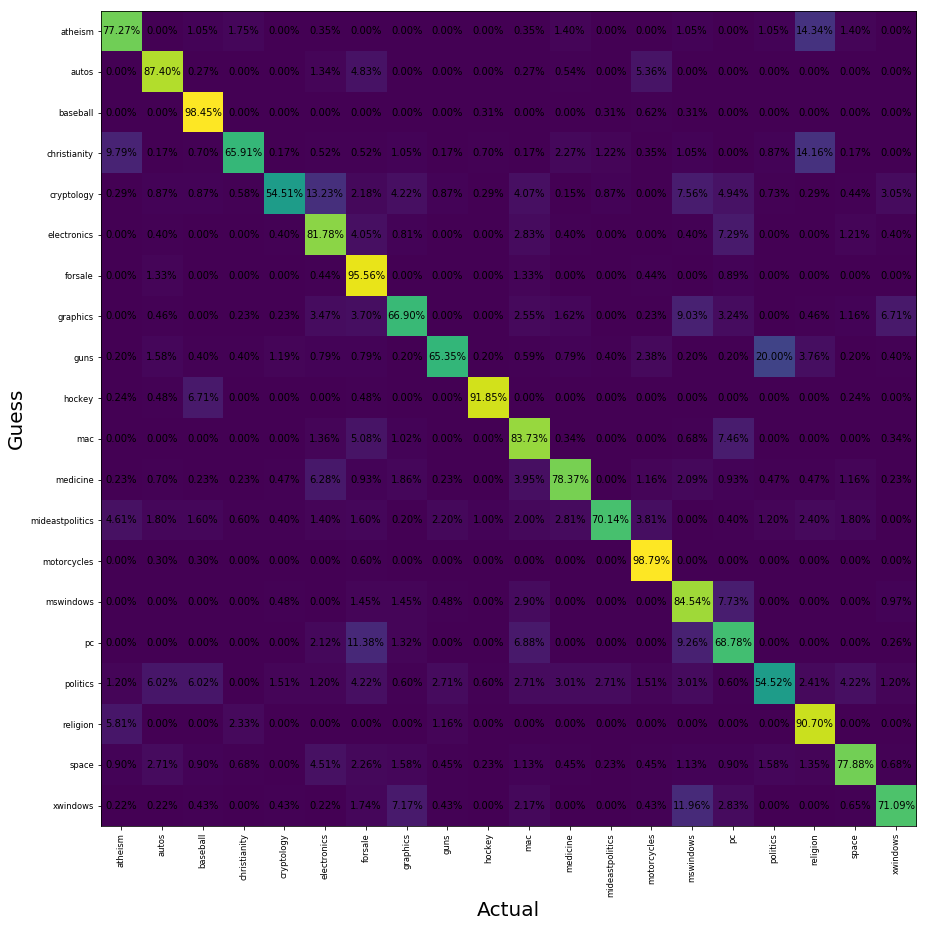

In [18]:
figs, axs = plt.subplots()
toplot = []
for g in gss_act:
    tot = sum(gss_act[g].values())
    toplot.append([gss_act[g][i]/tot for i in gss_act[g]])
figs.set_size_inches((15,15))
dat = [[gss_act[g][i]/sum(gss_act[g].values()) for i in gss_act[g]] for g in gss_act]
axs.imshow(dat)

for (j,i),label in np.ndenumerate(dat):
    axs.text(i,j,"%.2f%%"%(label*100),ha='center',va='center')
axs.set_ylabel("Guess",size=20)
axs.set_xlabel("Actual",size=20)
#ax.axes.set_xticklabels(labels=list(gss_act.keys()))
#ax.axes.set_yticklabels(labels=list(gss_act.keys()))
#ax.set_xticks(len(gss_act.keys()),list(gss_act.keys()))
#ax.set_yticks(ticks=list(gss_act.keys()))
plt.xticks(range(len(gss_act.keys())), list(gss_act.keys()),size="small",rotation='vertical')
plt.yticks(range(len(gss_act.keys())), list(gss_act.keys()),size="small")
plt.show()

In [13]:
gss_act

{'atheism': {'atheism': 221,
  'autos': 0,
  'baseball': 3,
  'christianity': 5,
  'cryptology': 0,
  'electronics': 1,
  'forsale': 0,
  'graphics': 0,
  'guns': 0,
  'hockey': 0,
  'mac': 1,
  'medicine': 4,
  'mideastpolitics': 0,
  'motorcycles': 0,
  'mswindows': 3,
  'pc': 0,
  'politics': 3,
  'religion': 41,
  'space': 4,
  'xwindows': 0},
 'autos': {'atheism': 0,
  'autos': 326,
  'baseball': 1,
  'christianity': 0,
  'cryptology': 0,
  'electronics': 5,
  'forsale': 18,
  'graphics': 0,
  'guns': 0,
  'hockey': 0,
  'mac': 1,
  'medicine': 2,
  'mideastpolitics': 0,
  'motorcycles': 20,
  'mswindows': 0,
  'pc': 0,
  'politics': 0,
  'religion': 0,
  'space': 0,
  'xwindows': 0},
 'baseball': {'atheism': 0,
  'autos': 0,
  'baseball': 317,
  'christianity': 0,
  'cryptology': 0,
  'electronics': 0,
  'forsale': 0,
  'graphics': 0,
  'guns': 0,
  'hockey': 1,
  'mac': 0,
  'medicine': 0,
  'mideastpolitics': 1,
  'motorcycles': 2,
  'mswindows': 1,
  'pc': 0,
  'politics': 0,


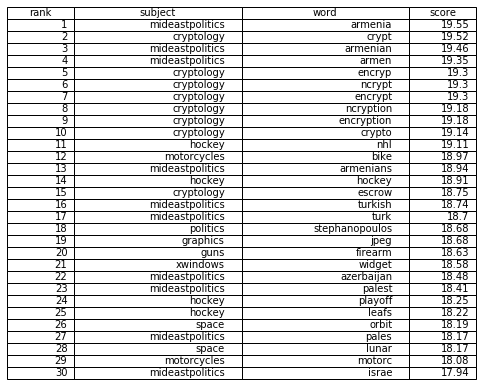

In [49]:
figs, axs = plt.subplots()
#figs.set_size_inches((15,15))
table = pd.DataFrame(topLst).reset_index()
table = table[['index','subject','word','score']]
table['index'] = table['index'].apply(lambda x:x+1)
table['score'] = table['score'].apply(lambda x: float("%.2f"%x))
table.rename(columns={'index': 'rank'},inplace=True)
cell_text = []
for row in range(len(table)):
    cell_text.append(table.iloc[row])
axs.table(cellText=cell_text,colLabels=table.columns, loc='center',colWidths=[0.2,.5,.5,.2])
axs.axis('off')
plt.show()

In [24]:
topLst[0].keys()

dict_keys(['subject', 'word', 'score'])

In [36]:
x ={'a':1}
y={'b':2}
{**x,**y}

{'a': 1, 'b': 2}

In [1]:
x = [[1,2,3],[4,5,6],[7,8,9]]
[k for i in x for k in i]

[1, 2, 3, 4, 5, 6, 7, 8, 9]